<a href="https://colab.research.google.com/github/juacardonahe/Curso_NLP/blob/main/1_FundamentosNLP/1.4_FoundationModels/1_4_2_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/juacardonahe/Curso_NLP/refs/heads/main/data/UnFieldB.png" width="40%">

# **Natural Language Procesing (NLP)**
### Departamento de Ingeniería Eléctrica, Electrónica y Computación
#### Universidad Nacional de Colombia - Sede Manizales

#### Created by: Juan José Cardona H.
#### Reviewed by: Diego A. Perez

#**1.4.2 - Long Short-Term Memory Networks (LSTMs)**
In our above discussion on Recurrent Neural Networks (RNNs), we looked at how their design lets them process sequences effectively. This makes them perfect for tasks where the sequence and context of data matter, like analyzing time-series data or processing language.

Now, we’re moving on to a type of RNN that tackles one of the big challenges traditional RNNs face: managing long-term data dependencies. These are the **Long Short-Term Memory Networks (LSTMs)**, which are a step up in complexity. They use a system of gates that control how information flows through the network — deciding what to keep and what to forget over extended sequences.

## **1. Prepare Data**

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [2]:
import pandas as pd

# Load the dataset from a URL
url = "https://raw.githubusercontent.com/juacardonahe/Curso_NLP/refs/heads/main/data/SMSSpamCollection/SMSSpamCollection"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])
print(df.head())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


## **2. Explore the Data**
Next, we explore the dataset to understand its structure, including the number of entries and the distribution of spam vs. ham messages. This helps us identify potential issues like class imbalance.

In [3]:
tf.random.set_seed(42)

In [4]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

# Check the distribution of labels
print("\nClass Distribution:")
print(df['label'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

Class Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


## **3. Preprocess the Data**
Preprocessing converts the raw text into a format suitable for the LSTM model. This includes encoding labels, calculating an appropriate sequence length, splitting the data, tokenizing text, padding sequences, and handling class imbalance with weights.

In [5]:
# Encode labels: ham -> 0, spam -> 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Calculate max_length based on the 95th percentile of message lengths
df['message_length'] = df['message'].apply(lambda x: len(x.split()))
max_length = int(df['message_length'].quantile(0.95))
print(f"Max sequence length (95th percentile): {max_length}")

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train) # Convert list to numpy array
class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")

Max sequence length (95th percentile): 33
Vocabulary size: 7954
Class weights: {0: np.float64(0.577481212749417), 1: np.float64(3.7265886287625416)}


##**4. Build the LSTM Model**
We define the LSTM model architecture using Keras. It includes an embedding layer to convert words into vectors, an LSTM layer to process sequences, a dropout layer to prevent overfitting, and a dense layer for classification.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Display the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##**5. Compile the Model**
We compile the model by specifying the loss function (binary cross-entropy for binary classification), the optimizer (Adam), and the metric (accuracy) to monitor during training.

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

##**6. Train the model**
We train the model on the preprocessed training data, using early stopping to prevent overfitting. Class weights are applied to address the imbalance between spam and ham.

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2,
                    class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8132 - loss: 0.4907 - val_accuracy: 0.9596 - val_loss: 0.1803
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9734 - loss: 0.1035 - val_accuracy: 0.9821 - val_loss: 0.0789
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9889 - loss: 0.0382 - val_accuracy: 0.9809 - val_loss: 0.0928
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9936 - loss: 0.0291 - val_accuracy: 0.9798 - val_loss: 0.1093
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9993 - loss: 0.0071 - val_accuracy: 0.9787 - val_loss: 0.0927


##**7. Visualize Training Performance**
We plot the training and validation accuracy and loss over epochs to assess how well the model is learning and to check for overfitting.

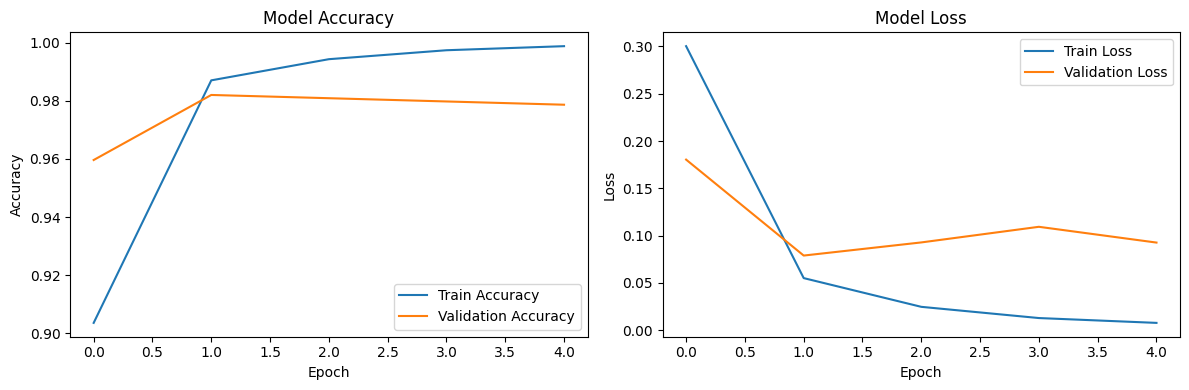

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

##**8. Evaluate the model**

In [10]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9808 - loss: 0.0637

Test Loss: 0.0536
Test Accuracy: 0.9883


##**9. Make predictions**
Finally, we create a function to classify new SMS messages and test it with example inputs, demonstrating the model's practical use.

In [11]:
# Function to predict spam or ham
def predict_spam(message):
    seq = tokenizer.texts_to_sequences([message])
    pad_seq = pad_sequences(seq, maxlen=max_length)
    prediction = model.predict(pad_seq, verbose=0)
    return 'spam' if prediction[0] > 0.5 else 'ham'

# Test with example messages
example_messages = [
    "Congratulations! You've won a free ticket to the Bahamas. Call now!",
    "Hey, are you free this weekend?"
]
for msg in example_messages:
    result = predict_spam(msg)
    print(f"\nMessage: {msg}")
    print(f"Prediction: {result}")


Message: Congratulations! You've won a free ticket to the Bahamas. Call now!
Prediction: spam

Message: Hey, are you free this weekend?
Prediction: ham


This notebook provides a complete guide to building, training, and evaluating an LSTM model for spam detection. You’ve learned how to preprocess text data, design a neural network, and interpret its performance—skills you can apply to other NLP tasks!